#### **0. 필요한 라이브러리 로드**

In [16]:
import pymysql
from sqlalchemy import create_engine
# pip install mysqlclient

import os
from abc import ABC, abstractmethod
from typing import *
import re

from prettytable import PrettyTable
import pandas as pd
pd.options.display.float_format = '{:.10f}'.format
import pprint

import binascii
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

#### **1. MySQL Server DB와 Python Script를 연동**

In [17]:
# import pymysql
# from abc import ABC, abstractmethod

class PreprocessQuery(ABC):
    """가명처리를 위한 개인정보 추출 목적의 SQL쿼리 추상클래스"""
    @abstractmethod
    def connectDatabase(self):
        """데이터베이스에 연결하기 위해 접속하는 메서드"""
        pass
    
    @abstractmethod
    def executeQuery(self, SQL):
        """SQL쿼리를 실행하는 메서드"""
        pass
    
    @abstractmethod
    def closeConnection(self):
        """데이터베이스와의 연결을 종료하는 메서드"""
        pass

In [18]:
class ConnectMySQLserver:
    def __init__(self, pw):
        self._pw = pw
        self.connection = None
        self.cursor = None
    
    def connectDatabase(self, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        """MySQL DBMS 데이터베이스에 접속 메서드
        : 서버IP주소, 사용자명, 계정 암호, 데이터베이스명, 한글 인코딩 방식"""
        try:
            self.connection = pymysql.connect(
                host=serverIP, port=port_num,
                user=user_name, password=self._pw,
                db=database_name, charset=kr_encoder
            )
            self.cursor = self.connection.cursor()
        except pymysql.Error as e:
            print(f"Error Connecting to MySQL from Python: {e}")
    
    def closeConnection(self):
        """연결 및 커서 닫기 메서드"""
        if self.cursor:
            self.cursor.close()
        if self.connection:
            self.connection.close()

In [19]:
# from pseudonymizer.encryptionPseudonyms.abstractPreprocessQuery import PreprocessQuery
# from typing import *
# import pymysql
# from prettytable import PrettyTable
# import pandas as pd

class PyMySQLQuery(PreprocessQuery):
    def __init__(self, pw):
        self._pw = pw
        self.connection = None
        self.DBconnection = ConnectMySQLserver(self._pw)
        self.cursor = None
        self.SQL = None
    
    def connectDatabase(self, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        """MySQL DBMS 데이터베이스에 접속하는 메서드"""
        self.DBconnection.connectDatabase(serverIP, port_num, user_name, database_name, kr_encoder)
    
    def dataQueryLanguage(self, sql):
        """SQL쿼리문 작성 메서드(데이터 추출 쿼리문 캡슐화)"""
        self.SQL = f"{sql}"

    def executeQuery(self):
        """SQL쿼리문 실행 및 예외처리 메서드(데이터베이스로 쿼리를 보내서 실행)"""
        try:
            # 데이터베이스에 연결되어 있지 않은 경우, 연결을 시도
            if self.DBconnection is None:
                raise pymysql.Error
            else:
            # 연결된 데이터베이스의 커서를 사용하여 쿼리를 실행
                self.DBconnection.cursor.execute(self.SQL)
                action_output = self.DBconnection.cursor.fetchall()
                return action_output
        
        except pymysql.Error as e:
            print(f"Error Executing Query: {e}")
        
    def executeQueryAsDataFrame(self):
        """SQL 쿼리를 실행한 결과를 판다스 데이터프레임으로 출력하는 메서드"""
        try:
            action_output = self.DBconnection.cursor.execute(self.SQL)
            records = self.DBconnection.cursor.fetchall()
            attributes = [i[0] for i in self.DBconnection.cursor.description]
            querydata = pd.DataFrame(records, columns = attributes)
            return querydata
        
        except pymysql.Error as e:
            print(f"Executing query error: {e}")

    def useFetchallQuery(self):
        """SQL 쿼리 실행 결과의 cursor.fetchall() 을 사용할 수 있도록 하는 메서드"""
        try:
            action_output = self.DBconnection.cursor.execute(self.SQL)
            records = self.DBconnection.cursor.fetchall()
            return records
        except pymysql.Error as e:
            print(f"Executing query error: {e}")
    
    def commitTransaction(self):
        """실행결과를 확정(트랜잭션을 커밋)하는 메서드"""
        self.DBconnection.connection.commit()
    
    def closeConnection(self):
        """데이터베이스와의 연결을 종료하는 메서드"""
        self.DBconnection.close_connection()

    def executeQueryAsDataFrame(self):
        """SQL 쿼리를 실행한 결과를 판다스 데이터프레임으로 출력하는 메서드"""
        try:
            action_output = self.DBconnection.cursor.execute(self.SQL)
            records = self.DBconnection.cursor.fetchall()
            attributes = [i[0] for i in self.DBconnection.cursor.description]
            querydata = pd.DataFrame(records, columns = attributes)
            return querydata
        
        except pymysql.Error as e:
            print(f"Executing query error: {e}")

___

#### **2. 데이터베이스 스키마.테이블 저장(역할과 책임에 따른 추상화)**

In [20]:
class DBContainer:
    """DB에서 스키마와 테이블 이름을 저장하고 반환하는 추상 클래스"""
    def __init__(self):
        self._schema = None
        self._table = None

    def setSchemaTable(self, schema: str, table: str):
        """스키마명, 테이블명 저장 추상 메서드"""
        self._schema = schema
        self._table = table
        
    def getSchema(self):
        """스키마 이름 반환 추상 메서드"""
        return self._schema
        
    def getTable(self):
        """테이블 이름 반환 추상 메서드"""
        return self._table

In [21]:
class BundleTables(ABC):
    """테이블을 저장하는 추상 클래스"""
    @abstractmethod
    def selectTables(self, data):
        """DBContainer에서 선언한 스키마.테이블 중 목적에 맞는 테이블을 저장하는 추상 메서드"""
        pass
    @abstractmethod
    def getTableList(self):
        """selectTables에서 선택한 데이터를 반환하는 추상 메서드"""
        pass
    @abstractmethod
    def getSchemas(self):
        """selectTables에서 선택한 스키마명 반환하는 추상 메서드"""
        pass
    @abstractmethod
    def getTables(self):
        """selectTables에서 선택한 테이블명 반환하는 추상 메서드"""
        pass    

In [22]:
class BundleMainTable(BundleTables):
    """가명정보 결합대상 원본테이블 저장 상속 클래스"""
    dbtables = None

    def __init__(self):
        self.dbtables = None

    def selectTables(self, tables: DBContainer):
        """가명정보 결합대상 원본테이블 저장하는 클래스"""
        self.dbtables = tables

    def getTableList(self):
        """가명정보 결합대상 원본테이블 반환하는 메서드"""
        return self.dbtables

    def getSchemas(self):
        """스키마명 반환하는 메서드"""
        return self.dbtables.getSchema()

    def getTables(self):
        """테이블명 반환하는 메서드"""
        return self.dbtables.getTable()

In [23]:
class BundleKeyTable(BundleTables):
    """결합키 생성 테이블 저장 상속 클래스"""
    dbtables = None
    key_column = None

    def __init__(self):
        self.key_table = None

    @classmethod
    def addDBTables(cls, tables: DBContainer):
        """DB에서 가명결합을 수행할 원본 테이블 캡슐화하는 메서드"""
        cls.dbtables = tables
    
    @classmethod
    def addKeyColumn(cls, key_column: str):
        """일방향 암호화 수행대상 결합키 컬럼명 설정하는 메서드"""
        cls.key_column = key_column

    def selectTables(self, key_table: DBContainer):
        """결합키 생성에 활용될 테이블 저장하는 클래스"""
        self.key_table = key_table

    def getTableList(self):
        """결합키 생성항목 테이블 반환하는 메서드"""
        return self.key_table

    def getSchemas(self):
        """스키마명 반환하는 메서드"""
        # return list(map(lambda table: table.getSchema(), self.key_table))
        return self.key_table.getSchema()

    def getTables(self):
        """테이블명 반환하는 메서드"""
        # return list(map(lambda table: table.getTable(), self.key_table))
        return self.key_table.getTable()

    @classmethod
    def reset(cls):
        """클래스 변수 초기화"""
        cls.dbtables = None
        cls.key_column = None


In [24]:
class BundleTargetTable(BundleTables):
    """결합대상 가명정보 테이블 저장 상속 클래스"""
    dbtables = None
    key_column = None

    def __init__(self):
        self.target_table = None

    @classmethod
    def addDBTables(cls, tables: DBContainer):
        """DB에서 가명결합을 수행할 원본 테이블 캡슐화하는 메서드"""
        cls.dbtables = tables

    def selectTables(self, target_table: DBContainer):
        """결합키 생성에 활용될 테이블 저장하는 클래스"""
        self.target_table = target_table

    def getTableList(self):
        """결합키 생성항목 테이블 반환하는 메서드"""
        return self.target_table

    def getSchemas(self):
        """스키마명 반환하는 메서드"""
        return self.target_table.getSchema()
        # return list(map(lambda table: table.getSchema(), self.target_table))

    def getTables(self):
        """테이블명 반환하는 메서드"""
        return self.target_table.getTable()
        # return list(map(lambda table: table.getTable(), self.target_table))

    @classmethod
    def reset(cls):
        """클래스 변수 초기화"""
        cls.dbtables = None
        cls.target_columns = None


In [ ]:
help(BundleTables)

---

#### **3. 일련번호 컬럼 생성, 결합키 생성항목 및 결합대상정보 분할, 결합키 암호화**

In [25]:
# from ./ import PyMySQLQuery
 
class UpdateSerialNumColumn(PyMySQLQuery):
    """원본 테이블에 결합키 생성을 위한 일련번호 컬럼을 생성하기 위한 쿼리를 날리는 클래스"""
    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        super().__init__(pw = pw)
        super().connectDatabase(
            serverIP, port_num, user_name, database_name, kr_encoder)
    
    def addSerialNumColumn(self, tables: DBContainer, serial_column, serial_text, identifier_column):
        """결합키 연계정보(매핑테이블) 생성에 활용될 각 결합신청자의 테이블별 일련번호 생성하는 실행 메서드"""
        schema = tables.getSchema()
        table = tables.getTable()
        if identifier_column is None:  
            # 컬럼명 중복시 해당 컬럼 삭제
            super().dataQueryLanguage(f"ALTER TABLE {schema}.{table} DROP COLUMN {serial_column}")  
            super().executeQuery()
            super().commitTransaction()

            # 일련번호 컬럼 생성
            super().dataQueryLanguage(f"ALTER TABLE {schema}.{table} ADD COLUMN {serial_column} VARCHAR(1000)")
            super().executeQuery()
            super().commitTransaction()

            # 0으로 초기화 후 @counter를 이용하여 1 더하여 일련번호 컬럼에 값 할당
            super().dataQueryLanguage("SET @counter = 0;")
            super().executeQuery()
            super().commitTransaction()

            super().dataQueryLanguage(f"UPDATE {schema}.{table} SET {serial_column} = CONCAT('{serial_text}', @counter := @counter + 1);")
            super().executeQuery()
            super().commitTransaction()
        else:
            pass

In [44]:
# from ./ import PyMySQLQuery
# from ./ import BundleMainTable
# from ./ import BundleKeyTable

class InsertKeyintoMainTable(PyMySQLQuery):
    """원본 테이블에서 결합키 생성항목으로 결합키 테이블을 생성하는 클래스"""
    bundleMainTable = BundleMainTable()
    bundleKeyTable = BundleKeyTable()

    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        super().__init__(pw = pw)
        super().connectDatabase(
            serverIP, port_num, user_name, database_name, kr_encoder)
        self.dbtables = None
        
    
    def insertKeyIntoDB(self, tables, key_table_info, key_table, join_key, salt_value, salt_column, serial_column, serial_text):
        """
        결합키를 테이블에 입력하는 실행 메서드
        -----------------------------------
        tables: pd.DataFrame 원본 데이터
        key_table_info: 결합키 생성항목 테이블 스키마, 테이블명 (DBContainer 타입)
        key_table: List 결합키 생성항목 대상 컬럼 조합
        key_column: str 생성할 결합키 컬럼명
        salt_value: str 일방향 암호화 해시값
        salt_column: str 외부에서 입력받을 해시값 컬럼명
        """
        # 원본 테이블 및 결합키 스키마.테이블명 등 로드
        key_schema, key_tablename, main_schema, main_tablename = self.loadTableObject(tables, key_table_info, join_key)

        # 결합키 컬럼 생성
        key_column = self.joinKeyColumn(key_table)
            # INPUT 결합키 생성 컬럼 -> OUTPUT 결합키 컬럼명
            
        # 데이터베이스 내 결합키 컬럼 기존재 시 삭제 및 삽입 수행 
        super().dataQueryLanguage(f"DROP TABLE IF EXISTS {key_schema}.{key_tablename}")
        super().executeQuery()

        sql = f"CREATE TABLE {key_schema}.{key_tablename} AS SELECT {serial_column}, {key_column} FROM {main_schema}.{main_tablename}"
        super().dataQueryLanguage(sql)
        super().executeQuery()
        super().commitTransaction()

        self.addKeyColumn(key_schema, key_tablename, join_key, key_column)
        self.addSaltColumn(key_schema, key_tablename, salt_value, salt_column)

        super().commitTransaction()

    @classmethod
    def loadTableObject(cls, tables, key_table_info, join_key):
        # 결합키 스키마.테이블명 등 로드
        
        cls.bundleKeyTable.addDBTables(tables) # 원본 데이터
        cls.bundleKeyTable.selectTables(key_table_info) # 키 데이터
        cls.bundleKeyTable.addKeyColumn(join_key) # 결합키 컬럼명
        cls.bundleKeyTable.getTableList()

        key_schema = cls.bundleKeyTable.getSchemas() # 키 테이블 스키마명
        key_tablename = cls.bundleKeyTable.getTables() # 키 테이블명

        # 원본 스키마.테이블명 로드
        cls.bundleMainTable.selectTables(tables)

        main_schema = cls.bundleMainTable.getSchemas()
        main_tablename = cls.bundleMainTable.getTables()

        return key_schema, key_tablename, main_schema, main_tablename
    
     
    @classmethod
    def joinKeyColumn(cls, key_column):
        return ", ".join(key_column)

    # @classmethod
    def addKeyColumn(self, key_schema, key_result, join_key, join_columns):
        """결합키 컬럼 만드는 클래스 메서드"""
        super().dataQueryLanguage(f"ALTER TABLE {key_schema}.{key_result} ADD COLUMN {join_key} VARCHAR(1000)")
        super().executeQuery()

        super().dataQueryLanguage(f"UPDATE {key_schema}.{key_result} SET {join_key} = CONCAT({join_columns})")
        super().executeQuery()
        super().commitTransaction()

    # @classmethod
    def addSaltColumn(self, key_schema, key_result, salt_value, salt_column):
        """SALT값 컬럼 만드는 클래스 메서드"""
        super().dataQueryLanguage(f"ALTER TABLE {key_schema}.{key_result} ADD COLUMN {salt_column} VARCHAR(1000)")
        super().executeQuery()

        super().dataQueryLanguage(f"UPDATE {key_schema}.{key_result} SET SALT = '{salt_value}'")
        super().executeQuery()

In [27]:
# from ./ import PyMySQLQuery
# from ./ import BundleMainTable
# from ./ import BundleTargetTable

class InsertTargetintoMainTable(PyMySQLQuery):
    """원본 테이블에서 결합대상 가명정보를 복사하여 테이블을 생성하는 클래스"""

    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        super().__init__(pw = pw)
        super().connectDatabase(
            serverIP, port_num, user_name, database_name, kr_encoder)
        self.dbtables = None
        self.bundleMainTable = BundleMainTable()
        self.bundleTargetTable = BundleTargetTable()
    
    def insertTargetIntoDB(self, tables, key_table):
        """
        결합키를 테이블에 입력하는 실행 메서드
        -----------------------------------
        tables: pd.DataFrame 원본 데이터
        key_table: List 결합키 생성항목 대상 컬럼 조합        

        """
        # 원본 테이블 및 결합키 스키마.테이블명 등 로드
        target_schema, target_tablename, main_schema, main_tablename = self.loadTableObject(tables, key_table)

        # 데이터베이스 내 결합키 컬럼 기존재 시 삭제 및 삽입 수행 
        super().dataQueryLanguage(f"DROP TABLE IF EXISTS {target_schema}.{target_tablename}")
        super().executeQuery()

        sql = f"CREATE TABLE {target_schema}.{target_tablename} AS SELECT * FROM {main_schema}.{main_tablename}"
        super().dataQueryLanguage(sql)
        super().executeQuery()
        super().commitTransaction()

        self.dropKeyColumn(target_schema, target_tablename, key_table)
        super().commitTransaction()

    @classmethod
    def loadTableObject(cls, tables, target_table):
        # 결합대상정보 등 스키마.테이블명 등 로드
        cls.bundleTargetTable.addDBTables(tables) # 원본 데이터
        cls.bundleTargetTable.selectTables(target_table) # 타겟 데이터
        cls.bundleTargetTable.getTableList()
        target_schema = cls.bundleTargetTable.getSchemas(cls.target_table) # 타겟 테이블 스키마명
        target_tablename = cls.bundleTargetTable.getTables(cls.target_table) # 타겟 테이블명

        # 원본 스키마.테이블명 로드
        main_schema = cls.bundleMainTable.getSchemas(tables)
        main_tablename = cls.bundleMainTable.getTables(tables)

        return target_schema, target_tablename, main_schema, main_tablename
     
    @classmethod
    def dropKeyColumn(cls, target_schema: str, target_tablename: str, key_table: list):
        """결합키 생성항목 원본 테이블에서 제거"""
        for column in key_table:
            drop_sql = f"ALTER TABLE {target_schema}.{target_tablename} DROP COLUMN {column}"
            super().dataQueryLanguage(drop_sql)
            super().executeQuery()

In [30]:
# from ./ import PyMySQLQuery

class EncryptoKeyColumn(PyMySQLQuery):
    """결합키 일방향 암호화 클래스"""
    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        super().__init__(pw = pw)
        super().connectDatabase(
            serverIP, port_num, user_name, database_name, kr_encoder)

    def encryptoKeytoHashvalue(self, hash_byte_type, key_schema, key_table, key_column, salt_column):
        """SHA256 혹은 SHA512를 통해 결합키 컬럼값을 해시값으로 일방향 암호화하는 메서드"""
        if hash_byte_type == 256:
            sql = f"UPDATE {key_schema}.{key_table} SET {key_column} = SHA2( CONCAT({key_column}, {salt_column}), hash_byte_standard )"
        elif hash_byte_type == 512:
            sql = f"UPDATE {key_schema}.{key_table} SET {key_column} = SHA2( CONCAT({key_column}, {salt_column}), hash_byte_standard )"
        else: 
            raise ValueError(f"일방향 암호화 단위로 {hash_byte_type}bit를 256bit와 512bit 중 하나를 입력해야 합니다.")
        
        super().dataQueryLanguage(sql)
        super().executeQuery()
        super().commitTransaction()

---

#### **3.2. 실행 클래스: 일련번호 컬럼 생성, 결합키 생성항목 및 결합대상정보 분할, 결합키 암호화**

In [28]:
# from ./ import PyMySQLQuery
# from ./ import UpdateSerialNumColumn
# from ./ import InsertKeyintoMainTable
# from ./ import InsertTargetintoMainTable
# from ./ import EncryptoKeyColumn

class UpdateEncryptedKeyIntoDB(PyMySQLQuery):
    """결합키 암호화 및 결합대상정보 테이블 생성 클래스"""
    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str, 
                 main_tablename: str, key_schema: str, key_tablename: str):
        super().__init__(pw = pw)
        super().connectDatabase(
            serverIP, port_num, user_name, database_name, kr_encoder)
        DQL = f"SELECT * FROM {main_tablename}"
        super().dataQueryLanguage(DQL)
        self.table = super().executeQueryAsDataFrame()
        super().commitTransaction()

        self.main_table = DBContainer()
        self.main_table.setSchemaTable(schema=database_name, table=main_tablename)

        self.key_table = DBContainer()
        self.key_table.setSchemaTable(schema=key_schema, table=key_tablename)

        self.updateSerialNumColumn = UpdateSerialNumColumn(pw, serverIP, port_num, user_name, database_name, kr_encoder)
        self.insertKeyintoMainTable = InsertKeyintoMainTable(pw, serverIP, port_num, user_name, database_name, kr_encoder)
        self.insertTargetintoMainTable = InsertTargetintoMainTable(pw, serverIP, port_num, user_name, database_name, kr_encoder)
        self.encryptoKeyColumn = EncryptoKeyColumn(pw, serverIP, port_num, user_name, database_name, kr_encoder)
    
    def __str__(self):
        return self.table.info()

    def UpdateintoDBTables(self, key_table, key_column, serial_column, serial_text, identifier_column, salt_value, salt_column, key_schema, hash_byte_type):
        """일련번호 컬럼 생성, 결합키 생성항목 및 결합 대상정보 테이블 입력, 결합키 암호화 실행 메서드"""
        self.updateSerialNumColumn.addSerialNumColumn(tables = self.main_table, serial_column = serial_column, 
                                serial_text = serial_text, 
                                identifier_column = identifier_column)
        
        self.insertKeyintoMainTable.insertKeyIntoDB(tables = self.main_table,
                                                    key_table_info=self.key_table, 
                                                    key_table = key_table, 
                                                    join_key = key_column,
                                                    salt_value = salt_value, 
                                                    salt_column = salt_column,
                                                    serial_column = serial_column, 
                                                    serial_text = serial_text)
        
        self.insertTargetintoMainTable.insertTargetIntoDB(tables = self.main_table, 
                                                          key_table = key_table)
        
        self.encryptoKeyColumn.encryptKeytoHashvalue(hash_byte_type = hash_byte_type, 
                                                     key_schema = key_schema, 
                                                     key_table = key_table, 
                                                     key_column = key_column, 
                                                     salt_column = salt_column)
        
    def printKeyTablesInfo(cls, schema_tablename: dict):
        """테이블 컬럼명 확인절차 실행 메서드"""
        # 키테이블명 딕셔너리 = {key(키 스키마) : value(키 테이블)}
        schema = schema_tablename.keys()[0]
        tablename = schema_tablename.values()[0]

        # 키테이블의 컬럼명(결합키, 일련번호, 솔트) 반환
        sql = f"SHOW COLUMNS FROM {schema}.{tablename}"
        super().dataQueryLanguage(sql)
        key_schema_tablenames = super().executeQueryAsDataFrame()["Field"].tolist()
        
        return key_schema_tablenames

---

#### **4. 매핑테이블 생성, 가명정보 테이블 결합**

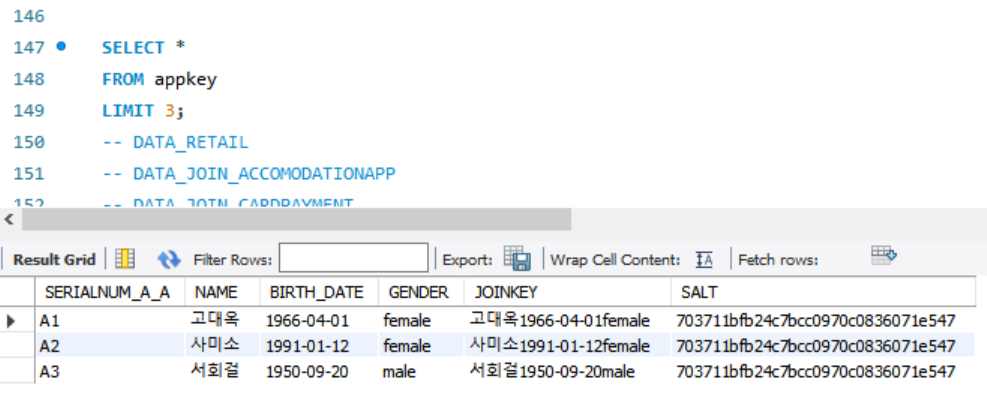

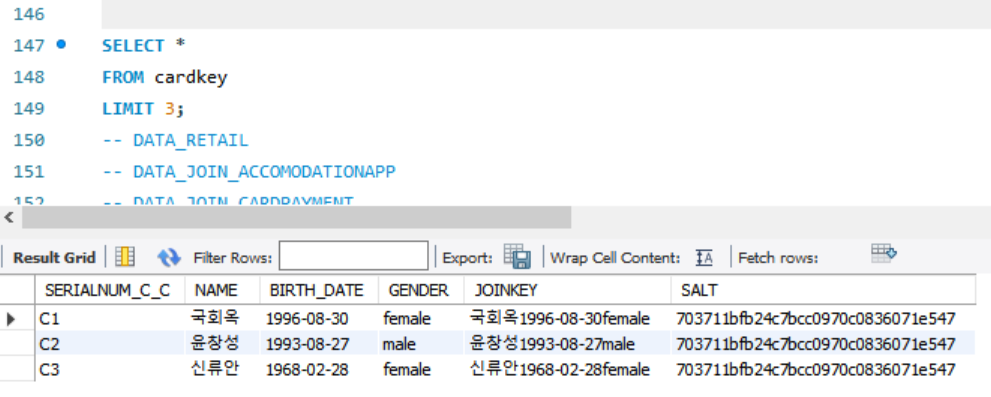

In [ ]:
class CreateMappingTable(PyMySQLQuery):
    """결합연계정보인 일련번호 컬럼 간 매핑테이블 생성 클래스"""
    columns = []

    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        super().__init__(pw = pw)
        super().connectDatabase(
            serverIP, port_num, user_name, database_name, kr_encoder)
        self.keytable_dictionary = {} # {key(키 스키마) : value(키 테이블)}
        self.mapping_table = None

    def joinKeyTables(self, mapping_schema: str, mapping_tablename: str, key_schemas: List, key_tablenames: List, joinkey_column: str, serialnum_columns: List):
        """일련번호 컬럼을 암호화된 결합키 기준으로 결합하여 매핑테이블 만드는 실행 메서드
        joinKeyTables
        -------------
        key_schemas: 각 테이블의 스키마를 담은 리스트
        key_tablenames: 각 테이블의 이름을 담은 리스트
        joinkey_column: 내부 조인에 사용할 컬럼 이름
        serialnum_columns: 일련번호 컬럼 이름들을 담은 리스트
        """
        schema, tablename = self.addMappingTable(mapping_schema, mapping_tablename)
        if self.checkKeyTableInfo(key_schemas, key_tablenames, joinkey_column, serialnum_columns):
            create_table_dql = f"CREATE TABLE {schema}.{tablename} AS "
            select_join_dql = self.createSelectJoinQuery(key_schemas, key_tablenames, joinkey_column, serialnum_columns)

            if len(key_tablenames) > 2:
                for i in range(2, len(key_tablenames)):
                    select_join_dql += f"{serialnum_columns[i]},
                        INNER JOIN {key_schemas[i]}.{key_tablenames[i]} ON {key_schemas[0]}.{key_tablenames[0]}.{joinkey_column} = {key_schemas[i]}.{key_tablenames[i]}.{joinkey_column} "
            else:
                pass
            select_join_dql = select_join_dql[:-2] + " "
            data_query_language = create_table_dql + select_join_dql
        else:
            pass

        super().dataQueryLanguage(data_query_language)
        super().executeQuery()
        super().commitTransaction()
    
    @classmethod
    def addMappingTable(cls, schema, tablename):
        # 매핑테이블의 스키마와 테이블명 DBContainer의 메서드 활용하여 생성 
        cls.mapping_table = DBContainer()
        cls.mapping_table.setSchemaTable(schema, tablename)
        schema = cls.addMappingTable.getSchema()
        tablename = cls.addMappingTable.getTable()

        return schema, tablename
    
    @classmethod
    def addColumns(cls, column: str):
        """컬럼명 추가 메서드"""
        cls.column = column

    @classmethod
    def checkKeyTableInfo(cls, key_schemas: List, key_tablenames: List, joinkey_column: str, serialnum_columns: List):
        for i in range(len(key_schemas)):
            check_query = f"SELECT 1 FROM {key_schemas[i]}.{key_tablenames[i]} WHERE {joinkey_column} IS NOT NULL AND "
            for col in serialnum_columns:
                check_query += f"{col} IS NOT NULL AND "
            check_query = check_query[:-5]

            # 검증 쿼리 실행
            cls.mapping_table.dataQueryLanguage(check_query)
            result = cls.mapping_table.executeQuery()

            # 검증 결과 확인
            if result:
                print(f"{key_schemas[i]}.{key_tablenames[i]} 테이블은 필요한 내부 조인 키와 일련번호 컬럼을 가지고 있습니다.")
            else:
                print(f"{key_schemas[i]}.{key_tablenames[i]} 테이블은 필요한 내부 조인 키와 일련번호 컬럼을 가지고 있지 않습니다.")

    @classmethod
    def createSelectJoinQuery(self, key_schemas: List, key_tablenames: List, joinkey_column: str, serialnum_columns: List):
        select_dql = f"SELECT {key_schemas[0]}.{key_tablenames[0]}.{joinkey_column}, 
                            {key_schemas[0]}.{key_tablenames[0]}.{serialnum_columns[0]}, 
                            {key_schemas[1]}.{key_tablenames[1]}.{serialnum_columns[1]} "
        
        from_dql = f"FROM {key_schemas[0]}.{key_tablenames[0]}.{joinkey_column} "
        join_dql = f"INNER JOIN {key_schemas[1]}.{key_tablenames[1]} "
        on_dql = f"ON {key_schemas[0]}.{key_tablenames[0]}.{joinkey_column} = {key_schemas[1]}.{key_tablenames[1]}.{joinkey_column}"

        return select_dql + from_dql + join_dql + on_dql

    # 0. 2개 이상의 키 스키마.테이블명을 입력 받음
    # 1. 동일한 솔트값, 동일한 알고리즘으로 일방향 암호화된 결합키 및 일련번호 컬럼을 가진 각 가명결합키 테이블을 로드
    # 2. 각 가명결합키 테이블의 결합키를 조인키로 활용하여 각 일련번호 컬럼 간 내부 조인 수행
    # 3. 조인을 수행한 뷰에서 조인키인 결합키를 삭제
    # 4. 내부 조인 쿼리결과 일련번호 결합 뷰를 새로운 매핑테이블로 DB 내 업데이트 
    # 5. checkKeyTableInfo() 메서드에서 실제로 key_schemas[i]를 DB스키마로 하는 key_tablenames[i]이라는 명칭의 테이블이 
        # joinkey_column과 serialnum_columns[i] 명칭의 컬럼을 가지고 있는지 유무를 확인하는 SQL 쿼리를 작성해서 
        # 맞으면 True 아니면 False를 반환하는 로직을 작성

```
pq = PyMySQLQuery(pw = "1234")
pq.connectDatabase(serverIP = "localhost", port_num = 3306, user_name = "root", database_name = "FINANCIALCONSUMER", kr_encoder = "utf8")

sql = "show columns from appkey"
pq.dataQueryLanguage(sql)
pf = pq.executeQueryAsDataFrame()
# pf
pf["Field"].tolist() # ['SERIALNUM_A', 'NAME', 'BIRTH_DATE', 'GENDER', 'JOINKEY', 'SALT']

a = {'a': 'b'}
type(a)
a.keys()
a.items()
a.values()
```

---

#### **4.2. 실행 클래스: 매핑테이블 생성, 가명정보 테이블 결합**

In [ ]:
class JoinTargetData(PyMySQLQuery):
    """매핑테이블의 일련번호를 기준으로 결합대상정보를 결합하는 클래스"""
    def __init__(self, pw: str, serverIP: str, port_num: int, user_name: str, database_name: str, kr_encoder: str):
        super().__init__(pw = pw)
        super().connectDatabase(serverIP, port_num, user_name, database_name, kr_encoder)

        self.target_tables = None
        self.mapping_table = None
        self.result = None

        self.targettable_dictionary = {} # {key(키 스키마) : value(키 테이블)}

    
    def addResult(self, result: DBContainer):
        """결합대상정보 결합 클래스 내용 주입"""
        self.result = result

    def joinDB(self):
        """매핑테이블의 일련번호를 기준으로 결합대상정보를 결합하는 메서드
           결합키를 제외한 컬럼명들을 SELECT에 나열하고, INNER JOIN을 한줄씩 더하기
        """
        schemas = self.target_tables.getSchemas()
        tables = self.target_tables.getTables()

        serial_cols = self.target_tables.serial_cols
        target_cols = ', '.join(self.target_tables.target_columns)

        mapping_schema = self.mapping_table.getSchema()
        mapping_table = self.mapping_table.getTable()
        result_schema = self.result.getSchema()
        result_table = self.result.getTable()

        create_sql = f"CREATE TABLE {result_schema}.{result_table} AS "
        select_sql = f"SELECT {mapping_schema}.{mapping_table}.*, {target_cols} "
        from_sql = f"FROM {mapping_schema}.{mapping_table} "
        join_sql = f""

        for i in range(len(tables)):
            join_sql += f"INNER JOIN {schemas[i]}.{tables[i]} ON {schemas[i]}.{tables[i]}.{serial_cols[i]} = {mapping_table}.{serial_cols[i]} "
            
        sql = create_sql + select_sql + from_sql + join_sql

        super().dataQueryLanguage(sql)
        super().executeQuery()

    @classmethod
    def addTargetTables(cls, schema_tablename: dict):
        # 키테이블명 딕셔너리 = {key(키 스키마) : value(키 테이블)}
        cls.targettable_dictionary = schema_tablename

    @classmethod
    def setTable(cls, table: DBContainer):
        cls.table = table

    @classmethod
    def addTable(cls, schema, tablename):
        # 매핑테이블의 스키마와 테이블명 DBContainer의 메서드 활용하여 생성 
        cls.addTable.setSchemaTable(schema, tablename)
        schema = cls.addTable.getSchema()
        tablename = cls.addTable.getTable()

        return schema, tablename

#### 테스트 스크립트

In [45]:
update_table = UpdateEncryptedKeyIntoDB(pw = "1234", serverIP = "localhost", port_num = 3306, user_name = "root", database_name = "FINANCIALCONSUMER", kr_encoder = "utf8", 
                                        main_tablename="DATA_JOIN_ACCOMODATIONAPP",
                                        key_schema="FINANCIALCONSUMER", key_tablename="APPKEY")

In [46]:
update_table.UpdateintoDBTables(key_table=["NAME", "GENDER", "PHONE_NUMBER"], key_column="JOINKEY",
                                serial_column="SERIALNUM_C", serial_text="C", identifier_column=None,
                                salt_value="adasdfserwerwerwsdffwer", salt_column="SALT",
                                key_schema="FINANCIALCONSUMER", hash_byte_type="256")

AttributeError: type object 'InsertTargetintoMainTable' has no attribute 'bundleTargetTable'

In [ ]:
update_table = UpdateSerialNumColumn(pw = "1234", serverIP = "localhost", port_num = 3306, user_name = "root", database_name = "FINANCIALCONSUMER", kr_encoder = "utf8")

In [ ]:
update_table.addSerialNumColumn(schema="FINANCIALCONSUMER", table="DATA_FINANCE", serial_column="SERIALNUM_A", 
                                serial_text="A", identifier_column=None)